# **Task 2 - Prediction of store sales**

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import HuberRegressor
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pickle
from datetime import datetime
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
from scripts.model import *
from scripts.logger import setup_logger

# 2.1 *Preprocessing*

# Load Data

In [2]:
train_data = pd.read_csv('../data/train_cleaned.csv', low_memory=False)
test_data = pd.read_csv('../data/test_cleaned.csv', low_memory=False)
store_data = pd.read_csv('../data/store.csv', low_memory=False)

# Properties of Data

In [3]:
train_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1017209 non-null  float64
 12  CompetitionOpenSinceMonth  1017209 non-null  float64
 13  CompetitionO

In [5]:
test_data.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [6]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             41088 non-null  int64  
 1   Store          41088 non-null  int64  
 2   DayOfWeek      41088 non-null  int64  
 3   Date           41088 non-null  object 
 4   Open           41088 non-null  float64
 5   Promo          41088 non-null  int64  
 6   StateHoliday   41088 non-null  object 
 7   SchoolHoliday  41088 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


In [7]:
train_data.isnull().sum()

Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [8]:
test_data.isnull().sum()

Id               0
Store            0
DayOfWeek        0
Date             0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [9]:
# change date type from object to datetime type
train_data.Date = pd.to_datetime(train_data["Date"])
test_data.Date=pd.to_datetime(test_data["Date"])
test_data = pd.merge(test_data, store_data, how= 'inner', on='Store')

In [10]:
test_data.isnull().sum()

Id                               0
Store                            0
DayOfWeek                        0
Date                             0
Open                             0
Promo                            0
StateHoliday                     0
SchoolHoliday                    0
StoreType                        0
Assortment                       0
CompetitionDistance             96
CompetitionOpenSinceMonth    15216
CompetitionOpenSinceYear     15216
Promo2                           0
Promo2SinceWeek              17232
Promo2SinceYear              17232
PromoInterval                17232
dtype: int64

In [11]:
test_data['Promo2SinceWeek'] = test_data['Promo2SinceWeek'].fillna(0)
test_data['Promo2SinceYear'] = test_data['Promo2SinceYear'].fillna(0)
test_data['PromoInterval'] = test_data['PromoInterval'].fillna(0)

In [12]:
test_data['CompetitionOpenSinceYear'] = test_data['CompetitionOpenSinceYear'].fillna(0)
test_data['CompetitionOpenSinceMonth'] = test_data['CompetitionOpenSinceMonth'].fillna(0)

In [13]:
median_distance = test_data['CompetitionDistance'].median()
test_data['CompetitionDistance'] = test_data['CompetitionDistance'].fillna(median_distance)

In [14]:
test_data.isnull().sum()

Id                           0
Store                        0
DayOfWeek                    0
Date                         0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

# Feature Extraction from Date Column

In [15]:
extract_date_features(train_data)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,IsWeekend,DayOfMonth,WeekOfYear,Season
0,1,4,2015-07-31,5263,555,1,1,0,1,c,...,0.0,0.0,0,2015,7,31,0,31,31,Summer
1,2,4,2015-07-31,6064,625,1,1,0,1,a,...,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,0,31,31,Summer
2,3,4,2015-07-31,8314,821,1,1,0,1,a,...,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,0,31,31,Summer
3,4,4,2015-07-31,13995,1498,1,1,0,1,c,...,0.0,0.0,0,2015,7,31,0,31,31,Summer
4,5,4,2015-07-31,4822,559,1,1,0,1,a,...,0.0,0.0,0,2015,7,31,0,31,31,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,1,2013-01-01,0,0,0,0,a,1,a,...,31.0,2013.0,"Jan,Apr,Jul,Oct",2013,1,1,0,1,1,Winter
1017205,1112,1,2013-01-01,0,0,0,0,a,1,c,...,0.0,0.0,0,2013,1,1,0,1,1,Winter
1017206,1113,1,2013-01-01,0,0,0,0,a,1,a,...,0.0,0.0,0,2013,1,1,0,1,1,Winter
1017207,1114,1,2013-01-01,0,0,0,0,a,1,a,...,0.0,0.0,0,2013,1,1,0,1,1,Winter


In [16]:
extract_date_features(test_data)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,IsWeekend,DayOfMonth,WeekOfYear,Season
0,1,1,3,2015-09-17,1.0,1,0,0,c,a,...,0.0,0.0,0,2015,9,17,0,17,38,Summer
1,2,3,3,2015-09-17,1.0,1,0,0,a,a,...,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,9,17,0,17,38,Summer
2,3,7,3,2015-09-17,1.0,1,0,0,a,c,...,0.0,0.0,0,2015,9,17,0,17,38,Summer
3,4,8,3,2015-09-17,1.0,1,0,0,a,a,...,0.0,0.0,0,2015,9,17,0,17,38,Summer
4,5,9,3,2015-09-17,1.0,1,0,0,a,c,...,0.0,0.0,0,2015,9,17,0,17,38,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,41084,1111,5,2015-08-01,1.0,0,0,0,a,a,...,31.0,2013.0,"Jan,Apr,Jul,Oct",2015,8,1,1,1,31,Summer
41084,41085,1112,5,2015-08-01,1.0,0,0,0,c,c,...,0.0,0.0,0,2015,8,1,1,1,31,Summer
41085,41086,1113,5,2015-08-01,1.0,0,0,0,a,c,...,0.0,0.0,0,2015,8,1,1,1,31,Summer
41086,41087,1114,5,2015-08-01,1.0,0,0,0,a,c,...,0.0,0.0,0,2015,8,1,1,1,31,Summer


In [17]:
# save the preprocessed data's
train_data.to_csv('../data/train_processed.csv', index=False)
test_data.to_csv('../data/test_processed.csv', index=False)

# Preprocessing for Numeric and Categorical Features

In [18]:
# Create and fit the preprocessing pipeline
preprocessor = create_preprocessing_pipeline()
X_train = train_data.drop(['Sales', 'Customers', 'Date'], axis=1)

In [19]:
X_train

,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,...,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,IsWeekend,DayOfMonth,WeekOfYear,Season
0,1,4,1,1,0,1,c,a,1270.0,9.0,...,0.0,0.0,0,2015,7,31,0,31,31,Summer
1,2,4,1,1,0,1,a,a,570.0,11.0,...,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,0,31,31,Summer
2,3,4,1,1,0,1,a,a,14130.0,12.0,...,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,0,31,31,Summer
3,4,4,1,1,0,1,c,c,620.0,9.0,...,0.0,0.0,0,2015,7,31,0,31,31,Summer
4,5,4,1,1,0,1,a,a,29910.0,4.0,...,0.0,0.0,0,2015,7,31,0,31,31,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,1,0,0,a,1,a,a,1900.0,6.0,...,31.0,2013.0,"Jan,Apr,Jul,Oct",2013,1,1,0,1,1,Winter
1017205,1112,1,0,0,a,1,c,c,1880.0,4.0,...,0.0,0.0,0,2013,1,1,0,1,1,Winter
1017206,1113,1,0,0,a,1,a,c,9260.0,0.0,...,0.0,0.0,0,2013,1,1,0,1,1,Winter
1017207,1114,1,0,0,a,1,a,c,870.0,0.0,...,0.0,0.0,0,2013,1,1,0,1,1,Winter


In [20]:
X_train.columns

Index(['Store', 'DayOfWeek', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'Year', 'Month',
       'Day', 'IsWeekend', 'DayOfMonth', 'WeekOfYear', 'Season'],
      dtype='object')

In [21]:
X_test = test_data.drop(['Id', 'Date'], axis=1)

In [22]:
preprocessor.fit(train_data)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['Store', 'DayOfWeek', 'DayOfMonth',
                                  'WeekOfYear', 'Year', 'Month',
                                  'CompetitionDistance',
                                  'CompetitionOpenSinceMonth',
                                  'CompetitionOpenSinceYear', 'Promo2SinceWeek',
                                  'Promo2SinceYear']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['StoreType', 'Assortment', 'StateHoliday',
                                  'SchoolHoliday', 'Season', 'Promo',
                                  'Promo2'])])

In [23]:
X_train_processed = preprocessor.transform(train_data)
print(X_train_processed)

[[-1.73164032  0.50148416  1.74076566 ...  1.          1.
   0.        ]
 [-1.72853385  0.50148416  1.74076566 ...  1.          0.
   1.        ]
 [-1.72542738  0.50148416  1.74076566 ...  1.          0.
   1.        ]
 ...
 [ 1.72275751 -1.00047591 -1.67312281 ...  0.          1.
   0.        ]
 [ 1.72586398 -1.00047591 -1.67312281 ...  0.          1.
   0.        ]
 [ 1.72897045 -1.00047591 -1.67312281 ...  0.          0.
   1.        ]]


In [24]:
X_test_processed = preprocessor.transform(test_data)
print(X_test_processed)

[[-1.73164032e+00  8.30805534e-04  1.47617711e-01 ...  1.00000000e+00
   1.00000000e+00  0.00000000e+00]
 [-1.72542738e+00  8.30805534e-04  1.47617711e-01 ...  1.00000000e+00
   0.00000000e+00  1.00000000e+00]
 [-1.71300149e+00  8.30805534e-04  1.47617711e-01 ...  1.00000000e+00
   1.00000000e+00  0.00000000e+00]
 ...
 [ 1.72275751e+00  1.00213752e+00 -1.67312281e+00 ...  0.00000000e+00
   1.00000000e+00  0.00000000e+00]
 [ 1.72586398e+00  1.00213752e+00 -1.67312281e+00 ...  0.00000000e+00
   1.00000000e+00  0.00000000e+00]
 [ 1.72897045e+00  1.00213752e+00 -1.67312281e+00 ...  0.00000000e+00
   0.00000000e+00  1.00000000e+00]]


In [25]:
y_train = train_data['Sales']
joblib.dump(X_train_processed, 'X_train_processed.joblib')
joblib.dump(X_test_processed, 'X_test_processed.joblib')
joblib.dump(y_train, 'y_train.joblib')

['y_train.joblib']

# 2.2 *Building models with sklearn pipelines*

In [26]:
# Assign the preprocessed data
X_train, X_test, y_train = X_train_processed,X_test_processed,y_train

# Split the training data further for evaluation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Build the model
model = build_model()

# Train the model with training data
trained_model = train_model(model, X_train, y_train)

# Model Evaluation

In [27]:
# Evaluate the model
mse, mae, rmse, r2, msle = evaluate_model(trained_model, X_val, y_val)
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")
print(f"MSLE: {msle}")

MSE: 823698.0139255588
MAE: 510.6021401312579
RMSE: 907.5781034850713
R2: 0.9443025649721308
MSLE: 0.27115472078233194


The pipeline approach not only simplified the model building process but also significantly improved the workflow by automating data preprocessing, model fitting, and evaluation. The **Random Forest Regressor** achieved excellent performance with an **R² score of 0.944**, indicating that the model explains approximately 94.4% of the variance in sales data.
- The **MSE of 823,698** and **RMSE of 907.57** are within acceptable ranges, showcasing the model's ability to make accurate predictions.
- While the **MAE of 510.60** indicates that, on average, the model's prediction deviates by about 511 sales units from the actual values, it still performs well for a baseline model.
- The relatively low **MSLE of 0.271** suggests that the model handles smaller errors well, which is important for making precise predictions.

This solid baseline model can now be enhanced with more advanced techniques, such as hyperparameter tuning, and used to compare performance against deep learning models like LSTMs. The combination of modular sklearn pipelines and the evaluation framework enables rapid experimentation and optimization of future models.

# 2.3 *Choose a loss function*

In [28]:
# Use the custom loss function in your pipeline or model evaluation
huber_model = HuberRegressor(max_iter=1000)  # You can adjust the number as needed

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
cross_val_score(huber_model, X_train, y_train, scoring=make_scorer(mean_squared_error))

array([8797288.19276311, 8862728.18610767, 8635559.95826229,
       8842800.13619564, 8863507.69949486])

**Why Huber Loss?**:
- **Handles outliers**: Balances robustness to outliers with maintaining sensitivity to large errors.
- **Smooth convergence**: Works well for datasets with both small and large deviations in sales.

**Conclusion**:

Huber Loss is ideal for this challenge as it provides a balance between **robustness** and **sensitivity to errors**, making it well-suited for **sales prediction** where both small and large errors must be controlled.

# 2.4 *Post Prediction Analysis*

# Feature Importance Analysis

In [29]:
# Assuming you have trained your model and created your preprocessor pipeline
feature_importance = get_feature_importance(trained_model, preprocessor)

# Display the top 10 important features
print(feature_importance.head(10))

                      feature  importance
1                   DayOfWeek    0.389526
6         CompetitionDistance    0.110915
18             StateHoliday_0    0.090211
0                       Store    0.088667
8    CompetitionOpenSinceYear    0.043173
29                    Promo_1    0.038554
28                    Promo_0    0.037806
7   CompetitionOpenSinceMonth    0.034302
12                StoreType_b    0.033548
10            Promo2SinceYear    0.021597


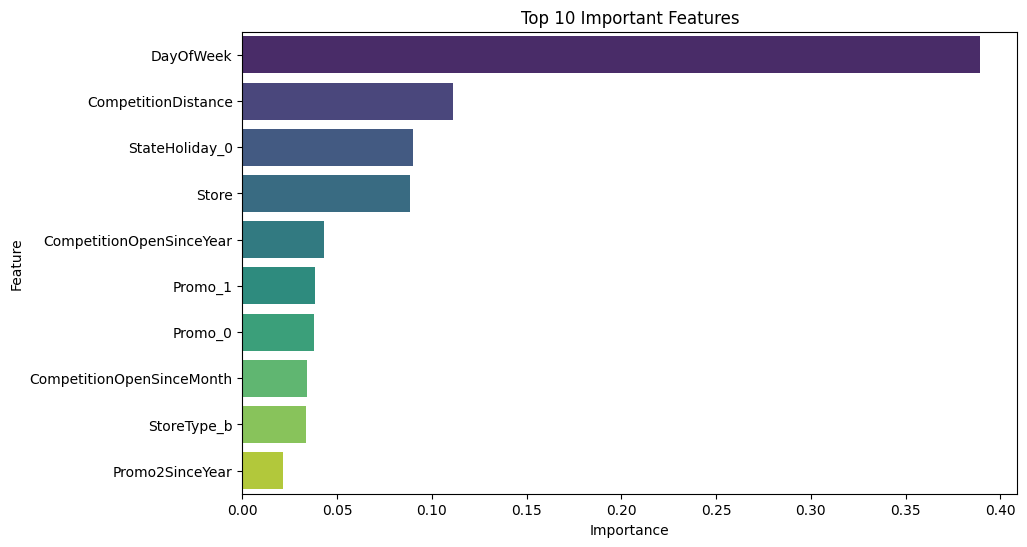

In [30]:
# Plot the top 10 important features
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(10)
sns.barplot(x="importance", y="feature", data=top_features, hue="feature", palette="viridis", legend=False)
plt.title("Top 10 Important Features")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# Estimate Confidence Intervals of Predictions

In [31]:
# Confidence Interval
y_pred = trained_model.predict(X_val)
lower_ci, upper_ci = calculate_confidence_interval(y_pred)
print(f"95% Confidence Interval: ({lower_ci}, {upper_ci})")

95% Confidence Interval: ([5764.25951132], [5779.09407864])


In [32]:
# Extract predictions from each individual tree in the forest
all_tree_preds = np.array([tree.predict(X_test) for tree in model.estimators_])

# Calculate the mean prediction and standard deviation
mean_preds = np.mean(all_tree_preds, axis=0)
std_preds = np.std(all_tree_preds, axis=0)

# Confidence Interval at 95%
lower_bound = mean_preds - 1.96 * std_preds  # Lower bound
upper_bound = mean_preds + 1.96 * std_preds  # Upper bound

# Print out the first few predictions and their intervals
for i in range(5):
    print(f"Prediction: {mean_preds[i]:.2f}, 95% Confidence Interval: [{lower_bound[i]:.2f}, {upper_bound[i]:.2f}]")

Prediction: 4422.52, 95% Confidence Interval: [3638.36, 5206.68]
Prediction: 7525.03, 95% Confidence Interval: [6589.05, 8461.02]
Prediction: 9405.66, 95% Confidence Interval: [7944.84, 10866.49]
Prediction: 7706.62, 95% Confidence Interval: [6681.31, 8731.93]
Prediction: 7730.98, 95% Confidence Interval: [6797.98, 8663.99]


# 2.5 *Serialize models*

In [33]:
# Serialize the model
model_path='../data'
model_filename = serialize_model(trained_model, model_path)
print(f"The ML Model serialized and saved as: {model_filename}")

The ML Model serialized and saved as: model_27-09-2024-17-21-25-092478.pkl


# 2.6 *Building model with Deep Learning*

# a. *Isolate the Rossmann Store Sales dataset into time series data*

In [34]:
# Sort the data by date
train_data.sort_index(inplace=True)

# Isolate the sales column
sales_data = train_data[['Sales']]

# Visualize the first few rows
print(sales_data.head())

   Sales
0   5263
1   6064
2   8314
3  13995
4   4822


# b. *Check whether your time Series Data is Stationary*

In [35]:
train_data['Date'] = pd.to_datetime(train_data['Date'])
data = train_data[['Date', 'Store', 'Sales']]

# Filter for a specific store (e.g., Store 1)
store_data = data[data['Store'] == 1]
store_data.set_index('Date', inplace=True)
store_data = store_data.resample('D').sum()

In [36]:
check_stationarity(store_data['Sales'])

ADF Statistic: -4.3681043682
p-value: 0.0003378835
Critical Values:
	1%: -3.4374778690
	5%: -2.8646866842
	10%: -2.5684454927
The time series is stationary


# c. *Differences of the time series data*

In [37]:
# Difference the series (store_data is a Series, no need to reference 'Sales')
adf_result = adfuller(store_data['Sales'])
if adf_result[1] >= 0.05:
    store_data['Sales'] = store_data['Sales'].diff().dropna()

# d. *Check for autocorrelation and partial autocorrelation of your data*

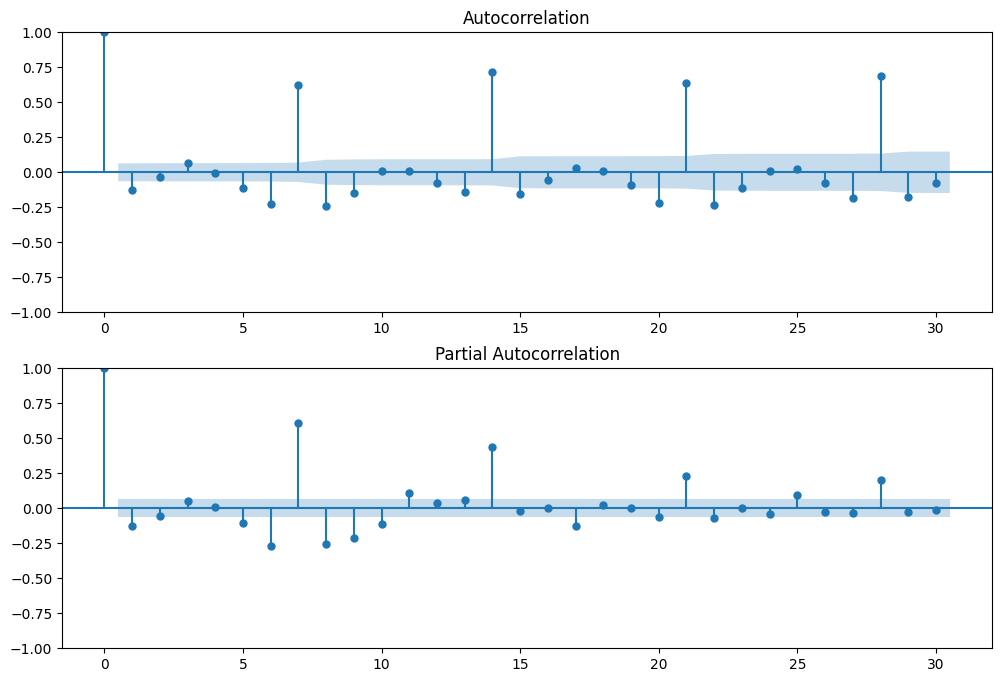

In [38]:
# Autocorrelation and Partial Autocorrelation plots
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(store_data['Sales'].dropna(), lags=30, ax=ax[0])
plot_pacf(store_data['Sales'].dropna(), lags=30, ax=ax[1])
plt.show()

# e. *Transform the time series data into supervised learning data by creating a new y(target) column*

In [39]:
# Define time steps
n_step = 30   # number of steps to use for prediction (30 days)
data_scaled = MinMaxScaler(feature_range=(-1, 1)).fit_transform(store_data['Sales'].values.reshape(-1, 1))
X, y = create_supervised_data(data_scaled, n_step)

# Reshape input to be [samples, n_steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# f. *Scale your data in the (-1, 1) range*

In [40]:
# Scale the data
scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(store_data['Sales'].values.reshape(-1, 1))

# Create dataset for LSTM
X, y = create_supervised_data(data_scaled, n_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

# g. *Build an LSTM Regression model to predict the next sale*

In [41]:
# Build and train the LSTM model
model = build_lstm_model(n_step)

In [42]:
# Train the model
history = train_lstm_model(model, X, y)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.1952 - val_loss: 0.1723
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1880 - val_loss: 0.1566
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1925 - val_loss: 0.1600
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1773 - val_loss: 0.1541
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1782 - val_loss: 0.1568
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1875 - val_loss: 0.1545
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1683 - val_loss: 0.1550
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1788 - val_loss: 0.1512
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1732 - val_loss: 0.1501
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1738 - val_loss: 0.1539
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1881 - val_loss: 0.1495
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1

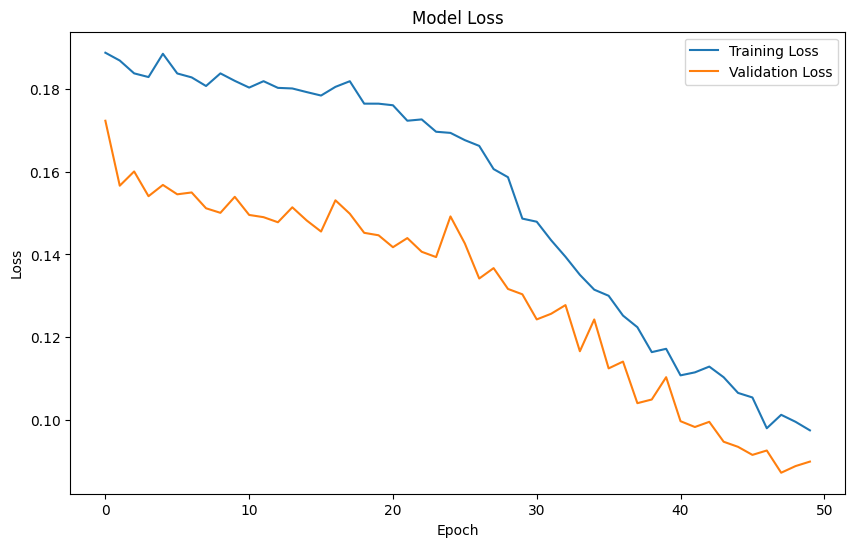

In [43]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [44]:
# Make predictions
predicted_sales = model.predict(X)

# Inverse transform to get actual sales values
predicted_sales = scaler.inverse_transform(predicted_sales.reshape(-1, 1))

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


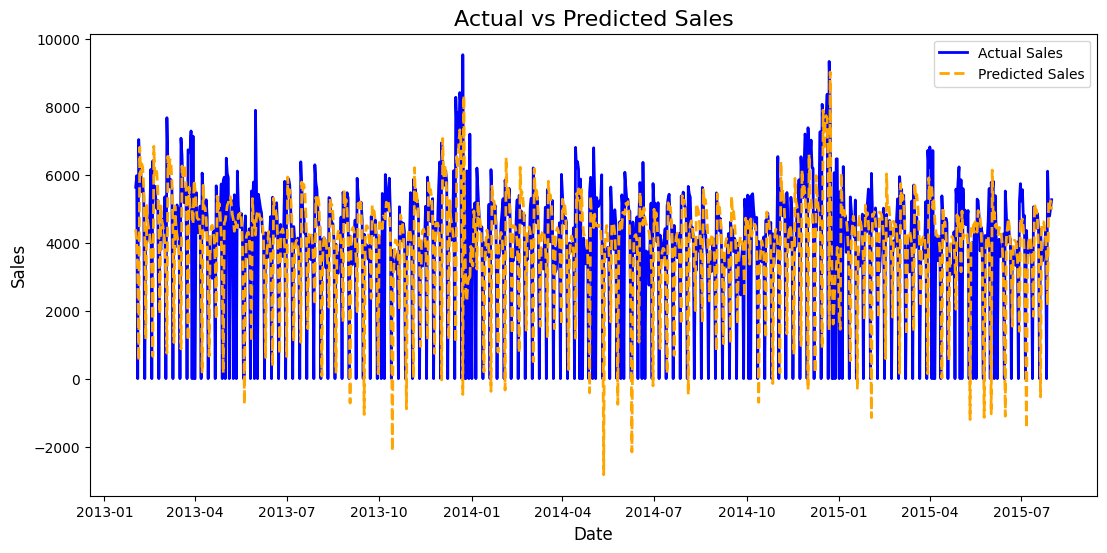

In [45]:
# Plot the the actual vs predicted results
plt.figure(figsize=(13, 6))
plt.plot(store_data.index[n_step+1:], store_data['Sales'][n_step+1:], 
         label='Actual Sales', color='blue', linestyle='-', linewidth=2)

# Plot the predicted sales
plt.plot(store_data.index[n_step+1:], predicted_sales, 
         label='Predicted Sales', color='orange', linestyle='--', linewidth=2)
plt.title('Actual vs Predicted Sales', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.legend()
plt.show()

In [46]:
# Calculate evaluation metrics
mse = mean_squared_error(store_data['Sales'][n_step+1:], predicted_sales)
mae = mean_absolute_error(store_data['Sales'][n_step+1:], predicted_sales)
rmse = np.sqrt(mse)
#r2=r2_score(store_data['Sales'][n_step+1:], predicted_sales)
#msle=mean_squared_log_error(store_data['Sales'][n_step+1:], predicted_sales)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (RMSE): {rmse}')

Mean Squared Error (MSE): 5350245.467089795
Mean Absolute Error (MAE): 1585.7910467288104
Mean Squared Error (RMSE): 2313.0597629740987
